#Setup

Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Constants

In [ ]:
ID_EXERCISE_LABEL       = -2
ID_SUBJECT_LABEL        = -1

NORM_SAMPLE_LENGTH = 100
CONSIDERED_SEGMENTS = ['RightHip', 'RightKnee', 'RightAnkle', 'LeftHip', 'LeftKnee', 'LeftAnkle']
# CONSIDERED_SEGMENTS = ['RightKnee']
CONSIDERED_AX = ['X', 'Y', 'Z']
# CONSIDERED_AX = ['X']

NUM_SUBJECT = 19 # subject 1 removed

In [ ]:
sorted(CONSIDERED_SEGMENTS)

['LeftAnkle', 'LeftHip', 'LeftKnee', 'RightAnkle', 'RightHip', 'RightKnee']

In [ ]:
# --- Model hyper-parameters --- #
# Fixed parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
ADAM_WEIGHT_DECAY = 1e-2
LEARNING_RATE_REDUCTION_FACTOR = 0.5

num_segment = len(CONSIDERED_SEGMENTS) # no. of considered segments for the data
num_ax = len(CONSIDERED_AX)
conv_num_in = num_segment*num_ax  # no. of inputs for the model
print('No. of considered segments: ' + str(num_segment))
print('No. of inputs for the model: ' + str(conv_num_in))

# Tuning parameters
BATCH_SIZE_GRID = [16, 32, 64, 128]
CONV_NUM_OUT_GRID = [32, 64, 128, 256]
KERNEL_SIZE_GRID = [4]
STRIDE_GRID = [1]
# POOL_SIZE = [2, 4, 8]
POOL_SIZE = [2]

# Id for tuning parameters
ID_BATCH_SIZE = 0
ID_NUM_OUT = 1
ID_KERNEL_SIZE = 2
ID_STRIDE = 3
ID_POOL_SIZE = 4

No. of considered segments: 6
No. of inputs for the model: 18


In [ ]:
# Generate the search space
hp_search_space = []

for bs in BATCH_SIZE_GRID:
  for no in CONV_NUM_OUT_GRID:
    for ks in KERNEL_SIZE_GRID:
      for st in STRIDE_GRID:
        for ps in POOL_SIZE:
          temp_point = [bs, no, ks, st, ps]
          hp_search_space.append(temp_point)

print('Size of the search space: ' + str(len(hp_search_space)))

Size of the search space: 16


Utils

In [ ]:
# all helper function here
# helper functions
def mkfolder(pth):
  if not os.path.exists(pth):
    os.mkdir(pth)

def read(pth):
  return pd.read_csv(pth)

# # Load and re-format the data file
# def load_df(pth):
#   dtframe = read(pth)
#   dtframe = dtframe.iloc[:, 1:] # remove the first column (i.e., index column)

#   # # Re-formatting the column's names
#   # names = list(dtframe.columns)
#   # names = [name.split('.')[0] for name in names]
#   # names_2 = dtframe.iloc[0, :]
#   # names_3 = dtframe.iloc[1, :]

#   # for i in range(len(names)):
#   #   names[i] = names[i]+' '+names_2[i]+' '+names_3[i]

#   # dtframe = dtframe.iloc[2:, :] # remove the first 2 rows
#   # dtframe.columns = names # update new column's names

#   return dtframe

# Load and re-format the data file
def load_df(pth):
  dtframe = read(pth)
  dtframe = dtframe.iloc[:, 1:] # remove the first column (i.e., index column)

  # Re-formatting the column's names
  names = list(dtframe.columns)
  names = [name.split('.')[0] for name in names]
  names_2 = dtframe.iloc[0, :]
  names_3 = dtframe.iloc[1, :]

  for i in range(len(names)):
    names[i] = names[i]+' '+names_2[i]+' '+names_3[i]

  dtframe = dtframe.iloc[2:, :] # remove the first 2 rows
  dtframe.columns = names # update new column's names

  return dtframe

def slice_df(dtframe):
  cols = sorted(dtframe.columns)

  req_cols = [col for col in cols if col.split(' ')[0] in CONSIDERED_SEGMENTS] # only keep data from considered sensors (may not be all 10), e.g., chest, pelvis, etc.
  req_cols = [col for col in req_cols if col.split(' ')[1] in CONSIDERED_AX] # not use information from orientation, magnetometer or time

  dtframe = dtframe.loc[:, req_cols]
  # print(dtframe)

  return dtframe

# One hot encoding
def one_hot_encoding(label, num_exercise):
  temp        = np.zeros(num_exercise)
  temp[label] = 1

  return temp

# One hot decoding
def one_hot_decoding(num):
  if num.shape[0] > 0:
    temp = np.array([np.where(row == 1) for row in num])
  else:
    temp = np.argwhere(num == 1)

  return temp

# Normalize data to have the same sample length for training the network
def normLength(arr, maxlength):
  new_arr = np.zeros((maxlength, arr.shape[-1]))
  for i in range(arr.shape[-1]):
    a = arr[:, i]
    k = a.shape[0]
    y = np.interp(np.linspace(0, 1, maxlength), np.linspace(0, 1, k), a)
    new_arr[:, i] = y
  return new_arr

Data handler

In [ ]:
class MyDataset(Dataset):
    def __init__(self, list_of_samples, to_size):
      self.to_size = to_size

      list_of_samples = [normLength(sample, NORM_SAMPLE_LENGTH).T for sample in list_of_samples]

      self.X = [sample[:ID_EXERCISE_LABEL, :] for sample in list_of_samples]
      
      self.Y = [one_hot_encoding(int(sample[ID_EXERCISE_LABEL, :][0]), num_exercise) for sample in list_of_samples]

    def __len__(self):
      return len(self.Y)

    def __getitem__(self, idx):
      x = torch.from_numpy(self.X[idx]).float()
      y = self.Y[idx]
      # y = int(self.Y[0])
      # y = np.array(y)
      if device == 'cuda':
        x = x.to(device)
        y = torch.from_numpy(y)
        y = y.to(device)
      return x, y

Model

In [ ]:
class CNN_Alter_Block(nn.Module):
    def __init__(self, num_in, num_out, kernel_size, stride, pool_size):
        super(CNN_Alter_Block, self).__init__()
        self.conv1    = nn.Conv1d(num_in, num_out, kernel_size, stride)      # input paramters
        self.relu1    = nn.ReLU()
        self.bnorm    = nn.BatchNorm1d(num_out)
        self.pooling  = nn.MaxPool1d((pool_size))

        self.flatten  = nn.Flatten()
        self.dropout  = nn.Dropout(p = 0.5)
        self.fcl      = nn.LazyLinear(out_features = 37)
        self.sfmx     = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.cuda()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bnorm(x)
        x = self.pooling(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fcl(x)
        x = self.sfmx(x)
        return x

Evaluate prediction

In [ ]:
# ---> Remember to check one more time before running the loop
def predict(some_tensor, labs):
  some_tensor = some_tensor.cpu().detach().numpy()
  labs        = labs.cpu().detach().numpy()

  count = 0

  for i in range(some_tensor.shape[0]):
    temp_pred = np.argmax(some_tensor[i])
    temp_truth = np.argmax(labs[i])

    # print('Prediction = ' + str(temp_pred) + ' - ' + 'Truth = ' + str(temp_truth))

    if temp_pred == temp_truth:
      count = count + 1
    else:
      pass # do nothing
  
  return count

Model loop

In [ ]:
val_acc, best_val_loss = 0, 1.0
def train_loop(dataloader, model, loss_fn, optimizer):
    global train_mode
    train_mode = True

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct, sched_factor = 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # print(X)
        # Compute prediction and loss
        pred = model(X)
        # print(pred)
        # print(predict(pred, y))
        # print('----------------------')
        # print(pred)
        # print(y)
        # break
        y = y.type(torch.FloatTensor)
        if device == 'cuda': y = y.cuda()

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        correct     += predict(pred, y)
        train_loss  += loss_fn(pred, y).item()

    train_loss /= num_batches
    train_losses.append(train_loss)
    correct /= size

    scheduler.step(train_loss)

    # print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return correct

def val_loop(dataloader, model, loss_fn):
    global val_acc, train_mode, best_val_loss
    train_mode = False

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            # pred = predict(pred, y)
            y = y.type(torch.FloatTensor)
            if device == 'cuda': y = y.cuda()
            val_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item() # comment out
            correct += predict(pred, y)


    val_loss /= num_batches
    val_losses.append(val_loss)
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    model_name = 'MaxJump5050_lstm_fcn_all_32_1en4_sch_801010_wd.pt'
    if correct > val_acc:
      torch.save(model, model_name)
      val_acc = correct
      best_val_loss = val_loss
      print('Model saved\n')
    elif correct == val_acc and val_loss < best_val_loss:
      torch.save(model, model_name)
      best_val_loss = val_loss
      print('Model saved\n')

def test_loop(dataloader, model, loss_fn):
    global train_mode
    train_mode = False

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, size = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            # pred = predict(pred, y)
            y = y.type(torch.FloatTensor)
            if device == 'cuda': y = y.cuda()
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item() # comment out
            correct += predict(pred, y)
            size    += y.shape[0]

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct

LOSOCV

In [ ]:
def losocv_split_train_list(all_subject_id, test_subject):  
  train_list = [m for m in all_subject_id if m != test_subject]

  return train_list

#Subjects and exercises

In [ ]:
# THIS IS WHEN USING LOCAL MACHINE <------------------- NOTICE
# root_path = 'OneDrive/Documents/parsed_joint_angles_/'
root_path = 'OneDrive/Documents/parsed_joint_angles_all/'
subs = sorted(list(os.listdir(root_path)))
# subs = subs[:-1] # remove 'merged' # we don't have 'merged' in this folder

In [ ]:
# total should be 20
num_subject = len(subs)
num_subject

20

Obtain exercises

In [ ]:
exercises = [sorted(os.listdir(root_path+sub)) for sub in subs]

# Get types of exercises (i.e., physical activities)
exercise_types = []
for ex in exercises:
  exercise_types.extend(ex)

In [ ]:
for ex in exercises:
  print(len(ex), ex)

14 ['CMJDL', 'DropJumpDL', 'DropLandDL', 'HeelRaise', 'Lunge', 'MaxJump', 'Run', 'SqDL', 'SqHalfDL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJD

In [ ]:
exercise_types = np.array(exercise_types)
exercise_types, _ = np.unique(exercise_types, return_index=True)
exercise_types = exercise_types.tolist()
exercise_types

['BulgSq',
 'CMJDL',
 'CMJSL',
 'DeclineSq',
 'DropJumpDL',
 'DropJumpSL',
 'DropLandDL',
 'DropLandSL',
 'FwHop',
 'FwHopFast',
 'FwJump',
 'FwJumpFast',
 'HeelRaise',
 'LatHop',
 'LatHopFast',
 'LatJump',
 'LatJumpFast',
 'Lunge',
 'MaxHop',
 'MaxJump',
 'Pose',
 'Run',
 'RunCut',
 'RunDec',
 'SpainSq',
 'SplitJump',
 'SportJump',
 'SqDL',
 'SqHalfDL',
 'SqHalfSL',
 'SqSL',
 'StepDnH',
 'StepDnL',
 'StepUpH',
 'StepUpL',
 'SumoSq',
 'Walk']

In [ ]:
# total should be 37
num_exercise = len(exercise_types)
num_exercise

37

Label exercises

In [ ]:
exercise_code = list(range(0, num_exercise))
label_code = dict(zip(exercise_types, exercise_code))
code_label = dict(zip(exercise_code, exercise_types))

In [ ]:
label_code

{'BulgSq': 0,
 'CMJDL': 1,
 'CMJSL': 2,
 'DeclineSq': 3,
 'DropJumpDL': 4,
 'DropJumpSL': 5,
 'DropLandDL': 6,
 'DropLandSL': 7,
 'FwHop': 8,
 'FwHopFast': 9,
 'FwJump': 10,
 'FwJumpFast': 11,
 'HeelRaise': 12,
 'LatHop': 13,
 'LatHopFast': 14,
 'LatJump': 15,
 'LatJumpFast': 16,
 'Lunge': 17,
 'MaxHop': 18,
 'MaxJump': 19,
 'Pose': 20,
 'Run': 21,
 'RunCut': 22,
 'RunDec': 23,
 'SpainSq': 24,
 'SplitJump': 25,
 'SportJump': 26,
 'SqDL': 27,
 'SqHalfDL': 28,
 'SqHalfSL': 29,
 'SqSL': 30,
 'StepDnH': 31,
 'StepDnL': 32,
 'StepUpH': 33,
 'StepUpL': 34,
 'SumoSq': 35,
 'Walk': 36}

In [ ]:
code_label

{0: 'BulgSq',
 1: 'CMJDL',
 2: 'CMJSL',
 3: 'DeclineSq',
 4: 'DropJumpDL',
 5: 'DropJumpSL',
 6: 'DropLandDL',
 7: 'DropLandSL',
 8: 'FwHop',
 9: 'FwHopFast',
 10: 'FwJump',
 11: 'FwJumpFast',
 12: 'HeelRaise',
 13: 'LatHop',
 14: 'LatHopFast',
 15: 'LatJump',
 16: 'LatJumpFast',
 17: 'Lunge',
 18: 'MaxHop',
 19: 'MaxJump',
 20: 'Pose',
 21: 'Run',
 22: 'RunCut',
 23: 'RunDec',
 24: 'SpainSq',
 25: 'SplitJump',
 26: 'SportJump',
 27: 'SqDL',
 28: 'SqHalfDL',
 29: 'SqHalfSL',
 30: 'SqSL',
 31: 'StepDnH',
 32: 'StepDnL',
 33: 'StepUpH',
 34: 'StepUpL',
 35: 'SumoSq',
 36: 'Walk'}

Label subjects

In [ ]:
subs_code = list(range(0, num_subject))
subject_code = dict(zip(subs, subs_code))
code_subject = dict(zip(subs_code, subs))

#Collect samples

In [ ]:
sample_list, file_paths = [], []

# The number below depends on how many sensor information we'd like to use
# e.g., if we use 4 sensors: left and right thigh and shank, and 2 information:
# accelerometer (3 axes) and gyroscope (3 axes), we would have 4*(3+3) = 24, 
# since we have the last column for target --> 25 columns in total

# See parts_to_consider in the slice_df function to define this number
# not_25 = 0
# not_31 = 0
# not_37 = 0
# not_43 = 0
# not_49 = 0
# not_55 = 0
# not_61 = 0

# not_62 = 0 # 62 since we now added 1 more column at the end for subject ID


num_missing_dt = 0 # count number of files with missing data to remove them out
num_col_in_dt = 3 # adding exercise + subject labels

print("Number of columns that should be in the dataframe = " + str(num_col_in_dt))

no_of_samples = None

# Loop through subjects
for subject in tqdm(subs[:]): 
  print()
  print('Collecting data from subject ' + str(subject) + ' ...')

  for ex in exercise_types:
    # If the subject perform the task
    try:
      folder_path = root_path + subject + '/' + ex + '/'
      file_names = os.listdir(folder_path) # obtain all parsed data files
      no_of_samples = len(file_names) # to display the no. of samples lately

      for file_name in file_names:
        sample_path = folder_path + file_name 
        # print(sample_path)       
        df = load_df(sample_path) # load and re-format the data file
        # print(df)
        # df = slice_df(df) # pick data from considered sensors and remove unnecessary information
        df['target'] = label_code[ex] # add output for the data file
        # print(df)
        df['subject_id'] = subject_code[subject] # add subject id for the data
        # print(df)

        sample_arr = np.array(df).astype(float) # convert to numpy array type

        # Check if the data has all considered parts
        if sample_arr.shape[1] != num_col_in_dt:
          num_missing_dt += 1
        else:
          sample_list.append(sample_arr)

        # break
      # print('\n' + str(no_of_samples) + ' samples collected from ' + ex)
      
    except:
      # print('\n' + ex + ' was missing')
      pass # do nothing

  print() # TBD

Number of columns that should be in the dataframe = 3


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

  5%|████▎                                                                              | 1/19 [00:00<00:05,  3.38it/s]

 11%|████████▋                                                                          | 2/19 [00:00<00:05,  3.28it/s]

 16%|█████████████                                                                      | 3/19 [00:00<00:04,  3.28it/s]

 21%|█████████████████▍                                                                 | 4/19 [00:01<00:04,  3.30it/s]

 26%|█████████████████████▊                                                             | 5/19 [00:01<00:04,  3.28it/s]

 32%|██████████████████████████▏                                                        | 6/19 [00:01<00:04,  3.24it/s]

 37%|██████████████████████████████▌                                                    | 7/19 [00:02<00:03,  3.20it/s]

 42%|██████████████████████████████████▉                                                | 8/19 [00:02<00:03,  3.24it/s]

 47%|███████████████████████████████████████▎                                           | 9/19 [00:02<00:03,  3.32it/s]

 53%|███████████████████████████████████████████▏                                      | 10/19 [00:03<00:02,  3.33it/s]

 58%|███████████████████████████████████████████████▍                                  | 11/19 [00:03<00:02,  3.35it/s]

 63%|███████████████████████████████████████████████████▊                              | 12/19 [00:03<00:02,  3.32it/s]

 68%|████████████████████████████████████████████████████████                          | 13/19 [00:03<00:01,  3.27it/s]

 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [00:04<00:01,  3.28it/s]

 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [00:04<00:01,  3.15it/s]

 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [00:04<00:01,  2.99it/s]

 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [00:05<00:00,  3.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [00:05<00:00,  2.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.19it/s]

In [ ]:
len(sample_list)

0

In [ ]:
sample_list[0].shape

IndexError: ignored

In [ ]:
num_missing_dt

#EDA

Normalize samples

In [ ]:
norm_sample_list = []

for t_sample in tqdm(sample_list):
  t_norm_sample = normLength(t_sample, NORM_SAMPLE_LENGTH)
  norm_sample_list.append(t_norm_sample)

100%|███████████████████████████████████████████████████████████████████████████| 3211/3211 [00:00<00:00, 11919.84it/s]


In [ ]:
# Get the label (i.e., exercise type of a sample)
print(len(norm_sample_list))
print(norm_sample_list[300][0, -1])
print(norm_sample_list[300].shape)

3211
1.0
(100, 3)


Frame data

In [ ]:
dt_frame_raw = []
dt_frame = []
ex_label = []
num_samples = len(norm_sample_list)

for i in range(num_samples):
  dt_frame_raw.append(sample_list[i][:, 0:1].flatten('F'))
  dt_frame.append(norm_sample_list[i][:, 0:1].flatten('F'))
  ex_label.append(norm_sample_list[i][0, -2])

dt_frame_raw = np.array(dt_frame_raw, dtype=object)
dt_frame = np.array(dt_frame)
ex_label = np.array(ex_label)

In [ ]:
dt_frame.shape

(3211, 100)

In [ ]:
dt_frame_raw.shape

(3211,)

In [ ]:
ex_label.shape

(3211,)

In [ ]:
np.unique(ex_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

Plot

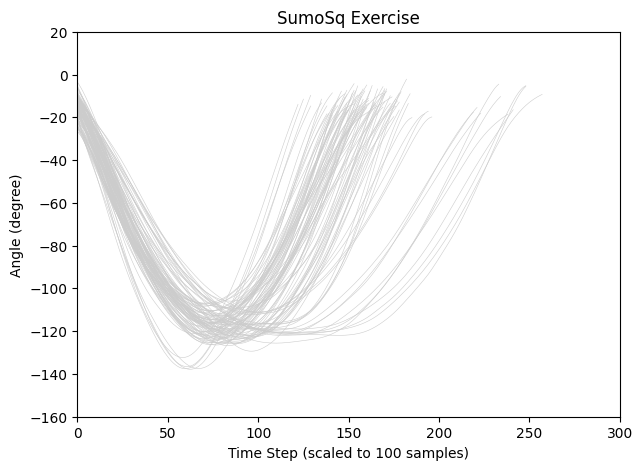

95


In [ ]:
num_samples = len(norm_sample_list)

# visualize a specific task
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
selected_exercise = exercise_types[35]
temp_no_samples = 0

ex_all_reps_line = []
for i in range(num_samples):
  if ex_label[i] == label_code[selected_exercise]:
    ax.plot(dt_frame_raw[i], linewidth = 0.4, color = '0.8')
    ex_all_reps_line.append(dt_frame[i, :])
    temp_no_samples += 1

# ax.set_xlim([0, 2300])
ax.set_xlabel('Time Step (scaled to 100 samples)')
ax.set_ylabel('Angle (degree)')
ax.set_title(selected_exercise + ' Exercise')

# ex_all_reps_line = np.array(ex_all_reps_line)
# ex_avg_line = np.mean(ex_all_reps_line, axis = 0)
# ax.plot(ex_avg_line, 'r--', linewidth = 1.2)
ax.set_xlim([0, 300])
ax.set_ylim([-160, 20])

# # The average line only
# fig1, ax1 = plt.subplots(figsize=(7,5), dpi=100)
# ax1.plot(ex_avg_line, 'r-', linewidth = 1.2)

# # ax1.set_xlim([0, 2300])
# ax1.set_xlabel('Time Step')
# ax1.set_ylabel('Undefined Unit')
# ax1.set_title(selected_exercise + ' Exercise')
# # ax1.set_ylim([-65, 65])

plt.show()
print(temp_no_samples)

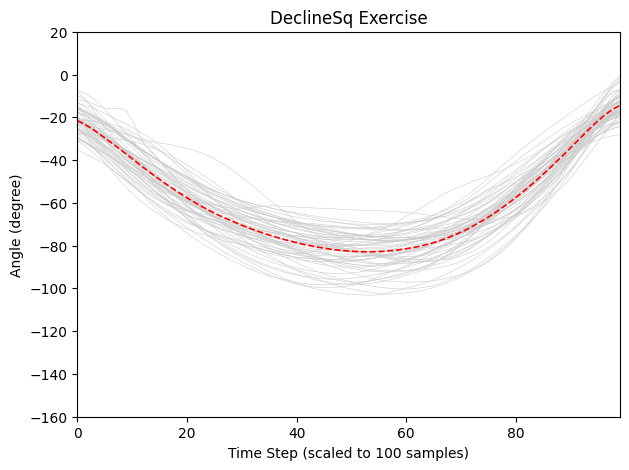

60


In [ ]:
num_samples = len(norm_sample_list)

# visualize a specific task
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
selected_exercise = exercise_types[3]
temp_no_samples = 0

ex_all_reps_line = []
for i in range(num_samples):
  if ex_label[i] == label_code[selected_exercise]:
    ax.plot(dt_frame[i, :], linewidth = 0.4, color = '0.8')
    ex_all_reps_line.append(dt_frame[i, :])
    temp_no_samples += 1

# ax.set_xlim([0, 2300])
ax.set_xlabel('Time Step (scaled to 100 samples)')
ax.set_ylabel('Angle (degree)')
ax.set_title(selected_exercise + ' Exercise')

ex_all_reps_line = np.array(ex_all_reps_line)
ex_avg_line = np.mean(ex_all_reps_line, axis = 0)
ax.plot(ex_avg_line, 'r--', linewidth = 1.2)
ax.set_xlim([0, 99])
ax.set_ylim([-160, 20])

# # The average line only
# fig1, ax1 = plt.subplots(figsize=(7,5), dpi=100)
# ax1.plot(ex_avg_line, 'r-', linewidth = 1.2)

# # ax1.set_xlim([0, 2300])
# ax1.set_xlabel('Time Step')
# ax1.set_ylabel('Undefined Unit')
# ax1.set_title(selected_exercise + ' Exercise')
# # ax1.set_ylim([-65, 65])

plt.show()
print(temp_no_samples)

Form the averaged data frames

In [ ]:
avg_dt_frame = []

for ex in range(num_exercise):
  
  temp_all_reps = []

  for i in range(num_samples):
    if ex_label[i] == ex:
      temp_all_reps.append(dt_frame[i, :])
    else:
      pass # do nothing

  temp_all_reps = np.array(temp_all_reps)
  avg_dt_frame.append(np.mean(temp_all_reps, axis = 0))

avg_dt_frame = np.array(avg_dt_frame)

In [ ]:
avg_dt_frame.shape

(37, 100)

Select number of clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertia = []
scaled_inertia = []
ch_id = []
silhouette = []

k = range(1, 20)

inertia_o = 0 # inertia when k = 1
alpha = 0.02

for num_clusters in k:
  kmeans = KMeans(n_clusters = num_clusters)
  kmeans.fit(avg_dt_frame)

  # Get inertia
  inertia.append(kmeans.inertia_)

  # Get scaled inertia
  if num_clusters == 1:
    inertia_o = kmeans.inertia_
  else:
    pass # do nothing

  scaled_inertia.append(kmeans.inertia_/inertia_o + alpha*num_clusters)

  # if num_clusters == 1:
  #   ch_id.append(0)
  #   silhouette.append(0)
  # else:
  #   # Get CH index
  #   labels = kmeans.labels_
  #   ch_id.append(metrics.calinski_harabasz_score(avg_dt_frame, labels))

  #   # Get Silhouette score
  #   silhouette.append(metrics.silhouette_score(avg_dt_frame, labels, metric='euclidean'))

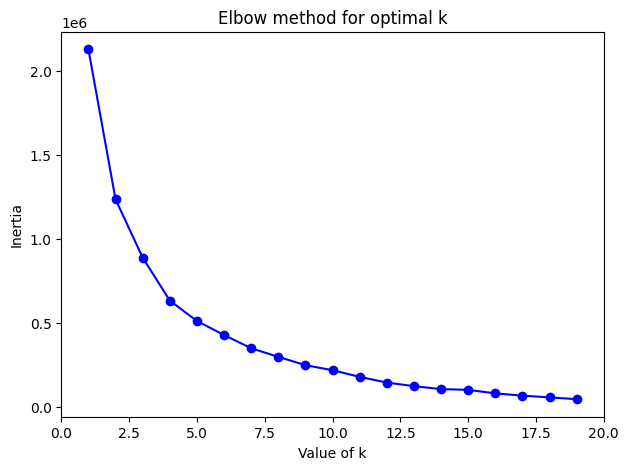

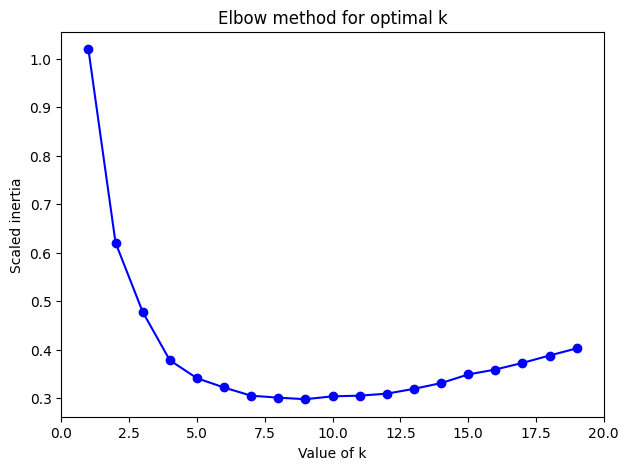

In [ ]:
# Plot inertia
plt.figure(figsize=(7,5), dpi=100)
plt.plot(k, inertia, 'bo-')
plt.xlabel('Value of k')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal k')
plt.xlim([0,20])
plt.show()

# Plot scaled inertia
plt.figure(figsize=(7,5), dpi=100)
plt.plot(k, scaled_inertia, 'bo-')
plt.xlabel('Value of k')
plt.ylabel('Scaled inertia')
plt.title('Elbow method for optimal k')
plt.xlim([0,20])
plt.show()

# # Plot CH indes
# plt.figure(figsize=(7,5), dpi=100)
# plt.plot(k[1:], ch_id[1:], 'bo-')
# plt.xlabel('Value of k')
# plt.ylabel('CH index')
# plt.title('Elbow method for optimal k')
# plt.xlim([0,20])
# plt.show()

# # Plot CH indes
# plt.figure(figsize=(7,5), dpi=100)
# plt.plot(k[1:], silhouette[1:], 'bo-')
# plt.xlabel('Value of k')
# plt.ylabel('Silhouette')
# plt.title('Elbow method for optimal k')
# plt.xlim([0,20])
# plt.show()

Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

kmeans = KMeans(n_clusters=5, random_state=0).fit(avg_dt_frame)

In [ ]:
# Form a distribution matrix
dist_mat = np.zeros([37, 5]) # init

for i in range(len(exercise_types)):
  row = int(i)
  col = int(kmeans.labels_[i])
  dist_mat[row, col] += 1

Text(8.222222222222218, 0.5, 'Exercise')

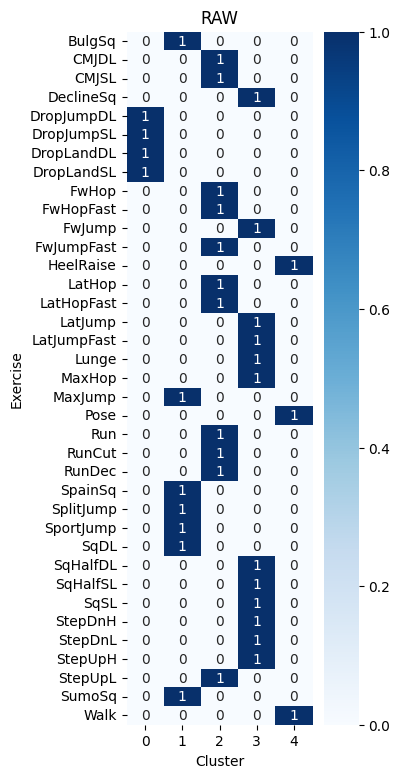

In [ ]:
import seaborn as sns

dist_mat = pd.DataFrame(dist_mat, index = exercise_types)

plt.figure(figsize = (3, 9))
sns.heatmap(dist_mat, annot = True, cmap = 'Blues')
plt.title('RAW')
plt.xlabel('Cluster')
plt.ylabel('Exercise')

#Collect samples

In [ ]:
sample_list, file_paths = [], []

# The number below depends on how many sensor information we'd like to use
# e.g., if we use 4 sensors: left and right thigh and shank, and 2 information:
# accelerometer (3 axes) and gyroscope (3 axes), we would have 4*(3+3) = 24, 
# since we have the last column for target --> 25 columns in total

# See parts_to_consider in the slice_df function to define this number
# not_25 = 0
# not_31 = 0
# not_37 = 0
# not_43 = 0
# not_49 = 0
# not_55 = 0
# not_61 = 0

# not_62 = 0 # 62 since we now added 1 more column at the end for subject ID


num_missing_dt = 0 # count number of files with missing data to remove them out
# num_col_in_dt = num_segment*num_ax + 2 # adding exercise + subject labels
num_col_in_dt = 17 + 2 # adding exercise + subject labels

print("Number of columns that should be in the dataframe = " + str(num_col_in_dt))

no_of_samples = None

# Loop through subjects
for subject in tqdm(subs[1:]): 
  print()
  print('Collecting data from subject ' + str(subject) + ' ...')

  for ex in exercise_types:
    # If the subject perform the task
    try:
      folder_path = root_path + subject + '/' + ex + '/'
      file_names = os.listdir(folder_path) # obtain all parsed data files
      no_of_samples = len(file_names) # to display the no. of samples lately

      for file_name in file_names:
        sample_path = folder_path + file_name        
        df = load_df(sample_path) # load and re-format the data file
        # df = slice_df(df) # pick data from considered sensors and remove unnecessary information
        df['target'] = label_code[ex] # add output for the data file
        df['subject_id'] = subject_code[subject] # add subject id for the data

        sample_arr = np.array(df).astype(float) # convert to numpy array type

        # Check if the data has all considered parts
        if sample_arr.shape[1] != num_col_in_dt:
          num_missing_dt += 1
        else:
          sample_list.append(sample_arr)

        # break
      # print('\n' + str(no_of_samples) + ' samples collected from ' + ex)
      
    except:
      # print('\n' + ex + ' was missing')
      pass # do nothing

  print() # TBD

Number of columns that should be in the dataframe = 19


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

  5%|████▎                                                                              | 1/19 [00:00<00:06,  2.89it/s]

 11%|████████▋                                                                          | 2/19 [00:00<00:06,  2.74it/s]

 16%|█████████████                                                                      | 3/19 [00:01<00:05,  2.72it/s]

 21%|█████████████████▍                                                                 | 4/19 [00:01<00:05,  2.74it/s]

 26%|█████████████████████▊                                                             | 5/19 [00:01<00:05,  2.76it/s]

 32%|██████████████████████████▏                                                        | 6/19 [00:02<00:04,  2.72it/s]

 37%|██████████████████████████████▌                                                    | 7/19 [00:02<00:04,  2.68it/s]

 42%|██████████████████████████████████▉                                                | 8/19 [00:02<00:04,  2.71it/s]

 47%|███████████████████████████████████████▎                                           | 9/19 [00:03<00:03,  2.74it/s]

 53%|███████████████████████████████████████████▏                                      | 10/19 [00:03<00:03,  2.73it/s]

 58%|███████████████████████████████████████████████▍                                  | 11/19 [00:04<00:02,  2.75it/s]

 63%|███████████████████████████████████████████████████▊                              | 12/19 [00:04<00:02,  2.75it/s]

 68%|████████████████████████████████████████████████████████                          | 13/19 [00:04<00:02,  2.75it/s]

 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [00:05<00:01,  2.76it/s]

 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [00:05<00:01,  2.66it/s]

 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [00:05<00:01,  2.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [00:06<00:00,  2.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [00:06<00:00,  2.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.67it/s]

In [ ]:
len(sample_list)

3206

In [ ]:
sample_list[0].shape

(197, 19)

In [ ]:
num_col_in_dt

19

#Visualization

Normalize samples

In [ ]:
norm_sample_list = []

for t_sample in tqdm(sample_list):
  t_norm_sample = normLength(t_sample, NORM_SAMPLE_LENGTH)
  norm_sample_list.append(t_norm_sample)

100%|████████████████████████████████████████████████████████████████████████████| 3206/3206 [00:01<00:00, 1786.86it/s]


In [ ]:
# Get the label (i.e., exercise type of a sample)
print(len(norm_sample_list))
print(norm_sample_list[300][0, -1])
print(norm_sample_list[300].shape)

3206
2.0
(100, 19)


Frame data

In [ ]:
dt_frame = []
ex_label = []
num_samples = len(norm_sample_list)

for i in range(num_samples):
  dt_frame.append(norm_sample_list[i][:, 0:18].flatten('F'))
  ex_label.append(norm_sample_list[i][0, ID_EXERCISE_LABEL])

dt_frame = np.array(dt_frame)
ex_label = np.array(ex_label)

In [ ]:
dt_frame.shape

(3206, 1800)

In [ ]:
ex_label.shape

(3206,)

In [ ]:
np.unique(ex_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

Visualize

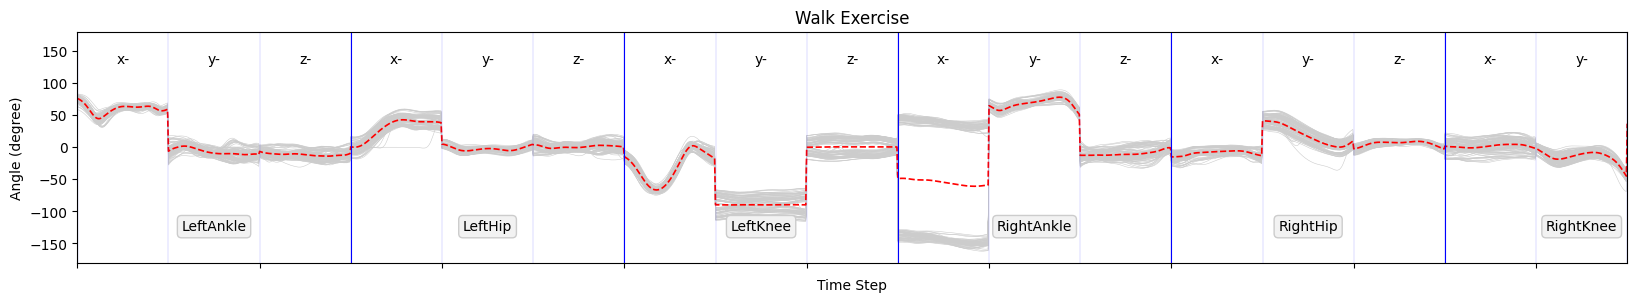

110


In [ ]:
# --- Plot --- #
# visualize a specific task
fig, ax = plt.subplots(figsize=(20,3), dpi=100)

selected_exercise = exercise_types[36]
temp_no_samples = 0

ex_all_reps_line = []
for i in range(num_samples):
  if ex_label[i] == label_code[selected_exercise]:
    ax.plot(dt_frame[i, :], linewidth = 0.4, color = '0.8')
    ex_all_reps_line.append(dt_frame[i, :])
    temp_no_samples += 1

# ax.set_xlim([0, 2300])
ax.set_xlabel('Time Step')
ax.set_ylabel('Angle (degree)')
ax.set_title(selected_exercise + ' Exercise')

ex_all_reps_line = np.array(ex_all_reps_line)
ex_avg_line = np.mean(ex_all_reps_line, axis = 0)
ax.plot(ex_avg_line, 'r--', linewidth = 1.2)
ax.set_xlim([0, 1700])
# ax.set_xlim([0, 300])
ax.set_ylim([-180, 180])
ax.set(xticklabels=[])  

# Segment different sensor positions
segment_info = sorted(CONSIDERED_SEGMENTS)
for i in range(len(segment_info)):
  ax.axvline(i*300, linewidth = 0.8, color = 'b')
  ax.annotate(segment_info[i], (i*300 + 150, -130), ha = 'center', bbox = dict(boxstyle ="round", fc ="0.95", ec = '0.8'))

# Segment different sensor type (i.e., accelerometer and gyroscope)
ga_label = sorted(['x-', 'y-', 'z-'])
for i in range(conv_num_in):
  ax.axvline(i*100, linewidth = 0.1, color = 'b')
  ax.annotate(ga_label[int(i % len(ga_label))], (i*100 + 50, 130), ha = 'center')

plt.show()
print(temp_no_samples)

#The loop

Check device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


The great loop

In [ ]:
# Removed subject 1 due to missing IMUs
all_subject_id = list(range(0, NUM_SUBJECT))

# Training/testing accuracy of performance evaluation
perf_train_acc = []
perf_test_acc = []

# Performance evaluation
for test_subject in all_subject_id[:]:
# for test_subject in all_subject_id:
  print('# Working on test subject ' + str(test_subject) + ' (' + subs[test_subject] + ')')

  # --- Divide training/testing data according to LOSOCV --- #
  train_list, test_list = [], []

  for sample in sample_list:    
    if sample[0, ID_SUBJECT_LABEL] != test_subject: # data not from the testing subject
      train_list.append(sample) 
    else: # data from the testing subject
      test_list.append(sample)

  ''' Hyper-parameters tuning loop with val_list '''
  # Get subject id from the train list
  train_subject_id = losocv_split_train_list(all_subject_id, test_subject)

  # Initialize the selected hyper-parameters
  s_batch_size = 0 
  s_num_out = 0
  s_kernel_size = 0
  s_stride = 0
  s_pool_size = 0

  hp_val_acc = 0

  # --- Loop throught the search space --- #
  print('--- Start the hyper-parameters searching')
  for hp_point in hp_search_space:

    t_bs = hp_point[ID_BATCH_SIZE]
    t_no = hp_point[ID_NUM_OUT]
    t_ks = hp_point[ID_KERNEL_SIZE]
    t_st = hp_point[ID_STRIDE] 
    t_ps = hp_point[ID_POOL_SIZE]

    temp_perf_val_acc = []

    for val_subject in train_subject_id:
      print('\t Val subject = ' + str(val_subject))

      # Divide training/val data according to LOSOCV
      temp_train_list, temp_val_list = [], []

      for sample in train_list:
        if sample[0, ID_SUBJECT_LABEL] != val_subject: # data not from the val subject
          temp_train_list.append(sample) 
        else: # data from the testing subject
          temp_val_list.append(sample)

      # Normalize data
      temp_train_data  = MyDataset(temp_train_list, NORM_SAMPLE_LENGTH)
      temp_test_data   = MyDataset(temp_val_list, NORM_SAMPLE_LENGTH)

      # Wrap dataloader   
      temp_train_dataloader  = DataLoader(temp_train_data, batch_size = t_bs, shuffle=True)
      temp_test_dataloader   = DataLoader(temp_test_data, batch_size  = t_bs, shuffle=False)

      # Model
      # temp_model = CNN_One_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Two_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Three_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_One_Deep_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Two_Deep_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Parallel_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      temp_model = CNN_Alter_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Alter_Two_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      if device == 'cuda': temp_model = temp_model.cuda()

      # for plotting
      train_losses, val_losses = [], []

      # Initialize the loss function
      temp_loss_fn = nn.CrossEntropyLoss()

      # Initialize the optimisation function
      temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

      # Scheduler
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(temp_optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

      for t in range(NUM_EPOCHS):
        # print(f"Epoch {t+1}\n-------------------------------")
        temp_train_acc  = train_loop(temp_train_dataloader, temp_model, temp_loss_fn, temp_optimizer)
        temp_val_acc   = test_loop(temp_test_dataloader, temp_model, temp_loss_fn)

      temp_perf_val_acc.append(temp_val_acc)

    # Update the hyper-parameters if getting better val accuracy
    temp_avg_val_acc = sum(temp_perf_val_acc)/len(train_subject_id)
    print('Temp. avg. val. acc. = ' + str(temp_avg_val_acc))

    if temp_avg_val_acc > hp_val_acc:
      # Update accuracy
      hp_val_acc = temp_avg_val_acc

      print('\t Parameters updated, and val_acc = ' + str(hp_val_acc))
      print('\t Parameters: ' + str(hp_point))

      # Update hyper-parameters
      s_batch_size = t_bs
      s_num_out = t_no
      s_kernel_size = t_ks
      s_stride = t_st
      s_pool_size = t_ps

    else:
      pass # do nothing

  print('--- Start the performance evaluation')
  # --- Make dataset --- #
  # Normalize
  train_data  = MyDataset(train_list, NORM_SAMPLE_LENGTH)
  test_data   = MyDataset(test_list, NORM_SAMPLE_LENGTH)

  # Wrap dataloader   
  train_dataloader  = DataLoader(train_data, batch_size = s_batch_size, shuffle=True)
  test_dataloader   = DataLoader(test_data, batch_size  = s_batch_size, shuffle=False)

  # --- Model and training --- #
  # Model
  # model = CNN_One_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Three_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_One_Deep_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Deep_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Parallel_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  model = CNN_Alter_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Alter_Two_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  if device == 'cuda': model = model.cuda()

  # for plotting
  train_losses, val_losses = [], []

  # Initialize the loss function
  loss_fn = nn.CrossEntropyLoss()

  # Initialize the optimisation function
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

  for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    temp_train_acc  = train_loop(train_dataloader, model, loss_fn, optimizer)
    temp_test_acc   = test_loop(test_dataloader, model, loss_fn)

  perf_train_acc.append(temp_train_acc)
  perf_test_acc.append(temp_test_acc)
  print(perf_train_acc)
  print(perf_test_acc)


# Working on test subject 0 (SUB02)
--- Start the hyper-parameters searching
	 Val subject = 1


C:\Users\ngvup\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Val subject = 6
	 Val subject = 7
	 Val subject = 8
	 Val subject = 9
	 Val subject = 10
	 Val subject = 11
	 Val subject = 12
	 Val subject = 13
	 Val subject = 14
	 Val subject = 15
	 Val subject = 16
	 Val subject = 17
	 Val subject = 18
Temp. avg. val. acc. = 0.7037732235358648
	 Parameters updated, and val_acc = 0.7037732235358648
	 Parameters: [16, 32, 4, 1, 2]
	 Val subject = 1
	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Val subject = 6
	 Val subject = 7
	 Val subject = 8
	 Val subject = 9
	 Val subject = 10
	 Val subject = 11
	 Val subject = 12
	 Val subject = 13
	 Val subject = 14
	 Val subject = 15
	 Val subject = 16
	 Val subject = 17
	 Val subject = 18
Temp. avg. val. acc. = 0.7400241406621837
	 Parameters updated, and val_acc = 0.7400241406621837
	 Parameters: [16, 64, 4, 1, 2]
	 Val subject = 1
	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Va

KeyboardInterrupt: ignored

In [ ]:
# Removed subject 1 due to missing IMUs
all_subject_id = list(range(0, NUM_SUBJECT))

# Training/testing accuracy of performance evaluation
perf_train_acc = []
perf_test_acc = []

# Performance evaluation
for test_subject in all_subject_id[:]:
# for test_subject in all_subject_id:
  print('# Working on test subject ' + str(test_subject) + ' (' + subs[test_subject] + ')')

  # --- Divide training/testing data according to LOSOCV --- #
  train_list, test_list = [], []

  for sample in sample_list:    
    if sample[0, ID_SUBJECT_LABEL] != test_subject: # data not from the testing subject
      train_list.append(sample) 
    else: # data from the testing subject
      test_list.append(sample)

  ''' Hyper-parameters tuning loop with val_list '''
  # Get subject id from the train list
  train_subject_id = losocv_split_train_list(all_subject_id, test_subject)

  # Initialize the selected hyper-parameters
  s_batch_size = 0 
  s_num_out = 0
  s_kernel_size = 0
  s_stride = 0
  s_pool_size = 0

  hp_val_acc = 0

  # --- Loop throught the search space --- #
  print('--- Start the hyper-parameters searching')
  for hp_point in hp_search_space:

    t_bs = hp_point[ID_BATCH_SIZE]
    t_no = hp_point[ID_NUM_OUT]
    t_ks = hp_point[ID_KERNEL_SIZE]
    t_st = hp_point[ID_STRIDE] 
    t_ps = hp_point[ID_POOL_SIZE]

    temp_perf_val_acc = []

    for val_subject in train_subject_id:
      print('\t Val subject = ' + str(val_subject))

      # Divide training/val data according to LOSOCV
      temp_train_list, temp_val_list = [], []

      for sample in train_list:
        if sample[0, ID_SUBJECT_LABEL] != val_subject: # data not from the val subject
          temp_train_list.append(sample) 
        else: # data from the testing subject
          temp_val_list.append(sample)

      # Normalize data
      temp_train_data  = MyDataset(temp_train_list, NORM_SAMPLE_LENGTH)
      temp_test_data   = MyDataset(temp_val_list, NORM_SAMPLE_LENGTH)

      # Wrap dataloader   
      temp_train_dataloader  = DataLoader(temp_train_data, batch_size = t_bs, shuffle=True)
      temp_test_dataloader   = DataLoader(temp_test_data, batch_size  = t_bs, shuffle=False)

      # Model
      # temp_model = CNN_One_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Two_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Three_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_One_Deep_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Two_Deep_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Parallel_Blocks(conv_num_in, t_no, t_ks, t_st, t_ps)
      temp_model = CNN_Alter_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      # temp_model = CNN_Alter_Two_Block(conv_num_in, t_no, t_ks, t_st, t_ps)
      if device == 'cuda': temp_model = temp_model.cuda()

      # for plotting
      train_losses, val_losses = [], []

      # Initialize the loss function
      temp_loss_fn = nn.CrossEntropyLoss()

      # Initialize the optimisation function
      temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

      # Scheduler
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(temp_optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

      for t in range(NUM_EPOCHS):
        # print(f"Epoch {t+1}\n-------------------------------")
        temp_train_acc  = train_loop(temp_train_dataloader, temp_model, temp_loss_fn, temp_optimizer)
        temp_val_acc   = test_loop(temp_test_dataloader, temp_model, temp_loss_fn)

      temp_perf_val_acc.append(temp_val_acc)

    # Update the hyper-parameters if getting better val accuracy
    temp_avg_val_acc = sum(temp_perf_val_acc)/len(train_subject_id)
    print('Temp. avg. val. acc. = ' + str(temp_avg_val_acc))

    if temp_avg_val_acc > hp_val_acc:
      # Update accuracy
      hp_val_acc = temp_avg_val_acc

      print('\t Parameters updated, and val_acc = ' + str(hp_val_acc))
      print('\t Parameters: ' + str(hp_point))

      # Update hyper-parameters
      s_batch_size = t_bs
      s_num_out = t_no
      s_kernel_size = t_ks
      s_stride = t_st
      s_pool_size = t_ps

    else:
      pass # do nothing

  print('--- Start the performance evaluation')
  # --- Make dataset --- #
  # Normalize
  train_data  = MyDataset(train_list, NORM_SAMPLE_LENGTH)
  test_data   = MyDataset(test_list, NORM_SAMPLE_LENGTH)

  # Wrap dataloader   
  train_dataloader  = DataLoader(train_data, batch_size = s_batch_size, shuffle=True)
  test_dataloader   = DataLoader(test_data, batch_size  = s_batch_size, shuffle=False)

  # --- Model and training --- #
  # Model
  # model = CNN_One_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Three_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_One_Deep_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Deep_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Parallel_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  model = CNN_Alter_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Alter_Two_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  if device == 'cuda': model = model.cuda()

  # for plotting
  train_losses, val_losses = [], []

  # Initialize the loss function
  loss_fn = nn.CrossEntropyLoss()

  # Initialize the optimisation function
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

  for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    temp_train_acc  = train_loop(train_dataloader, model, loss_fn, optimizer)
    temp_test_acc   = test_loop(test_dataloader, model, loss_fn)

  perf_train_acc.append(temp_train_acc)
  perf_test_acc.append(temp_test_acc)
  print(perf_train_acc)
  print(perf_test_acc)


# Working on test subject 0 (SUB02)
--- Start the hyper-parameters searching
	 Val subject = 1


C:\Users\ngvup\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Val subject = 6
	 Val subject = 7
	 Val subject = 8
	 Val subject = 9
	 Val subject = 10
	 Val subject = 11
	 Val subject = 12
	 Val subject = 13
	 Val subject = 14
	 Val subject = 15
	 Val subject = 16
	 Val subject = 17
	 Val subject = 18
Temp. avg. val. acc. = 0.7975800453194384
	 Parameters updated, and val_acc = 0.7975800453194384
	 Parameters: [16, 32, 4, 1, 2]
	 Val subject = 1
	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Val subject = 6
	 Val subject = 7
	 Val subject = 8
	 Val subject = 9
	 Val subject = 10
	 Val subject = 11
	 Val subject = 12
	 Val subject = 13
	 Val subject = 14
	 Val subject = 15
	 Val subject = 16
	 Val subject = 17
	 Val subject = 18
Temp. avg. val. acc. = 0.8233418848135915
	 Parameters updated, and val_acc = 0.8233418848135915
	 Parameters: [16, 64, 4, 1, 2]
	 Val subject = 1
	 Val subject = 2
	 Val subject = 3
	 Val subject = 4
	 Val subject = 5
	 Va

KeyboardInterrupt: ignored